# Header Import

In [1]:
# Data Manipulation Libraries
import timeit
import numpy as np 
import pandas as pd 
from scipy import stats

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer

# Machine Learning Models
from sklearn.linear_model import LinearRegression  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, \
                            max_error, mean_absolute_error, roc_auc_score
from sklearn.model_selection import train_test_split

import json
import joblib
import xgboost as xgb

# #Define IAM Role
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer


# S3 Bucket Configuration

In [2]:
# Set SageMaker and S3 client variables
sess = sagemaker.Session()

region =  'eu-central-1'
s3_client = boto3.client("s3", region_name=region)

sagemaker_role = sagemaker.get_execution_role()

bucket_name = 'bucket-ganesh'
read_prefix = 'bike-sharing-demand'

input_file = f"{read_prefix}/train.csv"
testing_file = f"{read_prefix}/test.csv"
training_file = f"{read_prefix}/bike_train.csv"
Validation_file = f"{read_prefix}/bike_validation.csv"
model_file = f"{read_prefix}/model" 

input_file_loc = f"s3://{bucket_name}/{input_file}" 
train_file_loc = f"s3://{bucket_name}/{training_file}" 
validation_file_loc = f"s3://{bucket_name}/{Validation_file}" 
test_file_loc = f"s3://{bucket_name}/{testing_file}" 


# Load the train Data

In [3]:
# Load tha train data.
train_data = pd.read_csv(input_file_loc, parse_dates = ['datetime'])
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Load the test Data

In [4]:
# Load tha test data.
test_data = pd.read_csv(test_file_loc, parse_dates = ['datetime'])
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# Data Analysis

In [5]:
def dataset_metadetails(df):
    print('\n Dimensions of dataset is {}' .format(df.shape))
    print("\n Dataset is having {} rows and {} features \n" .format(df.shape[0],df.shape[1]))
    print('\n Datatype of features:\n {}' .format(df.dtypes))
    plt.figure(figsize=(15,10))
    df.dtypes.value_counts().plot(kind='bar')
    plt.title('Number of datatypes')
    plt.xlabel('Datatypes')
    plt.ylabel('Count')
    plt.grid()
    plt.show()
    #print(df.dtypes.value_counts())
    print('\n Null data values in number of columns is {}' .format((df.isnull().any().sum())))
    print('\n Null data values in number of rows is {}'  .format((df.isnull().any(axis=1).sum())))
    
    
def data_preparation(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df.drop(columns=['datetime'], inplace=True)
    
    
#Getting data correlation    
def data_correlations(feature_name, target_name, df):
    correlations = []  # Initialize an empty list to store correlation data
    for feature in feature_name:
        feature_value = df[feature].values
        target_value = df[target_name].values
        correlation_value = stats.pearsonr(feature_value, target_value)[0]
        correlations.append({'correlation': feature + " & " + target_name,
                             'value': correlation_value})
    
    correlation = pd.DataFrame(correlations)  # Create the DataFrame from the list
    correlation = correlation.sort_values(by='value', ascending=False)
    return correlation
    


 Dimensions of dataset is (10886, 12)

 Dataset is having 10886 rows and 12 features 


 Datatype of features:
 datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object


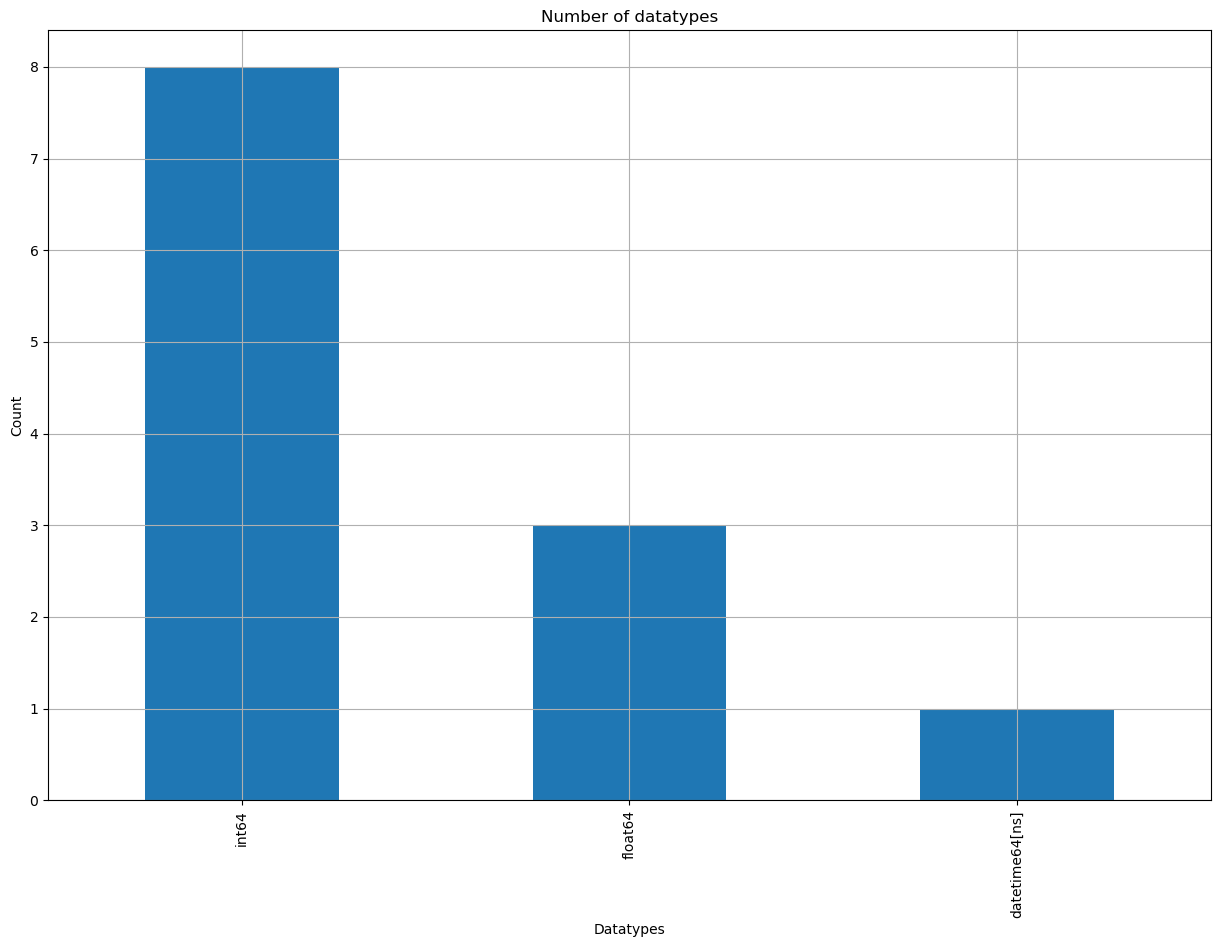


 Null data values in number of columns is 0

 Null data values in number of rows is 0


In [6]:
dataset_metadetails(train_data)


 Dimensions of dataset is (6493, 9)

 Dataset is having 6493 rows and 9 features 


 Datatype of features:
 datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object


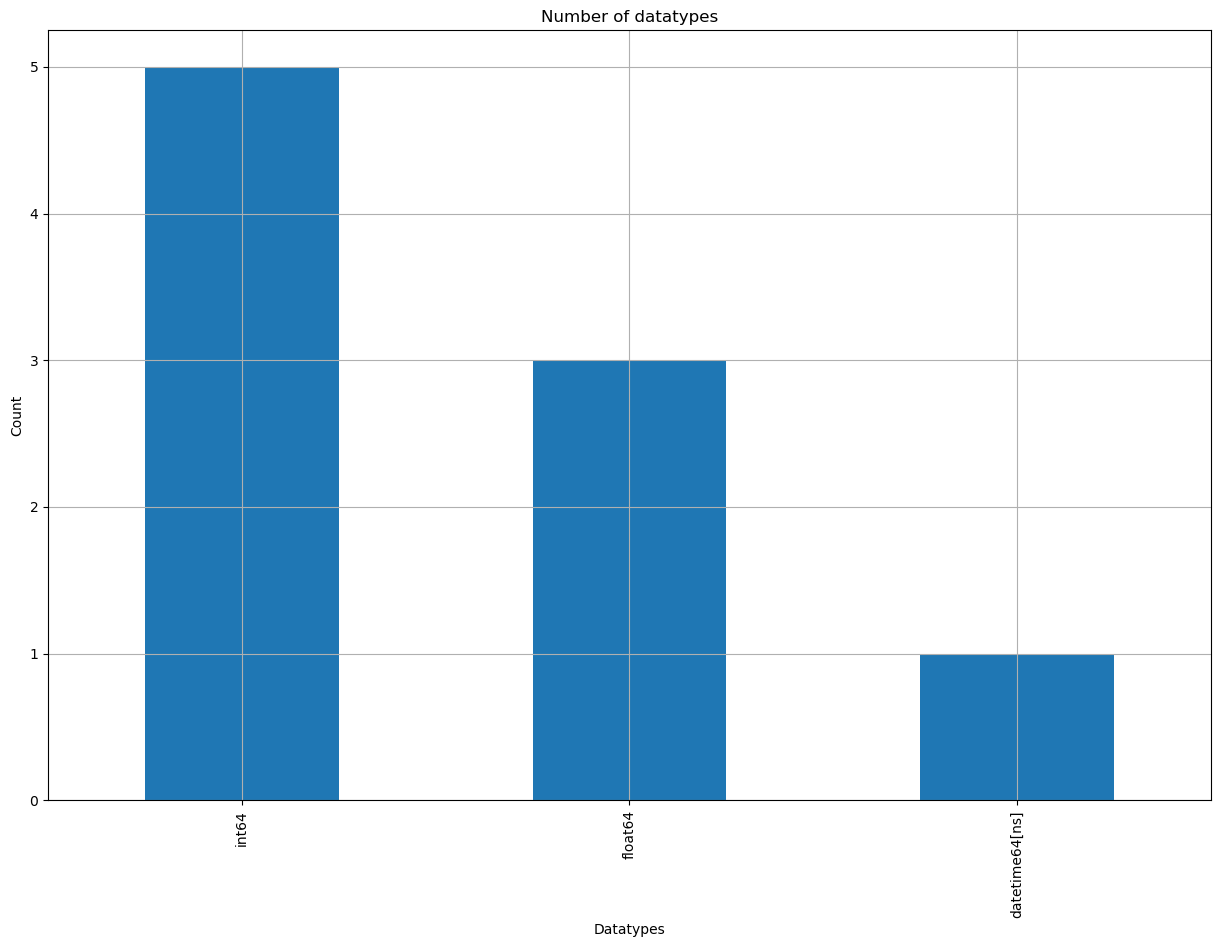


 Null data values in number of columns is 0

 Null data values in number of rows is 0


In [7]:
dataset_metadetails(test_data)

In [8]:
data_preparation(train_data)
data_preparation(test_data)

In [9]:
# Remove the "count" column from its current position
count_column = train_data.pop("count")

# Reinsert the "count" column at the beginning of the DataFrame
train_data.insert(0, "count", count_column)
train_data

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,day,hour
0,16,1,0,0,1,9.84,14.395,81,0.0000,3,13,2011,1,1,0
1,40,1,0,0,1,9.02,13.635,80,0.0000,8,32,2011,1,1,1
2,32,1,0,0,1,9.02,13.635,80,0.0000,5,27,2011,1,1,2
3,13,1,0,0,1,9.84,14.395,75,0.0000,3,10,2011,1,1,3
4,1,1,0,0,1,9.84,14.395,75,0.0000,0,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,336,4,0,1,1,15.58,19.695,50,26.0027,7,329,2012,12,19,19
10882,241,4,0,1,1,14.76,17.425,57,15.0013,10,231,2012,12,19,20
10883,168,4,0,1,1,13.94,15.910,61,15.0013,4,164,2012,12,19,21
10884,129,4,0,1,1,13.94,17.425,61,6.0032,12,117,2012,12,19,22


<Figure size 1500x1000 with 0 Axes>

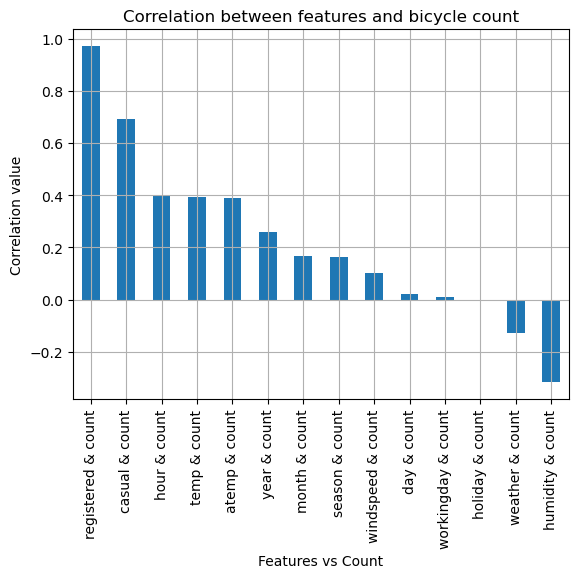

In [10]:
feature_name = train_data.iloc[:, 1:].columns
target_name = train_data.iloc[:, 0].name

# Calculate the correlations
correlation = data_correlations(feature_name, target_name, train_data)

# Create a bar plot
plt.figure(figsize=(15, 10))
correlation.plot(x="correlation", y="value", kind='bar', legend=False)
plt.title('Correlation between features and bicycle count')
plt.xlabel('Features vs Count')
plt.ylabel('Correlation value')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid()
plt.show()


In [11]:
groupby_hour = train_data.groupby(['hour'])
mean_hour = groupby_hour['count'].mean()

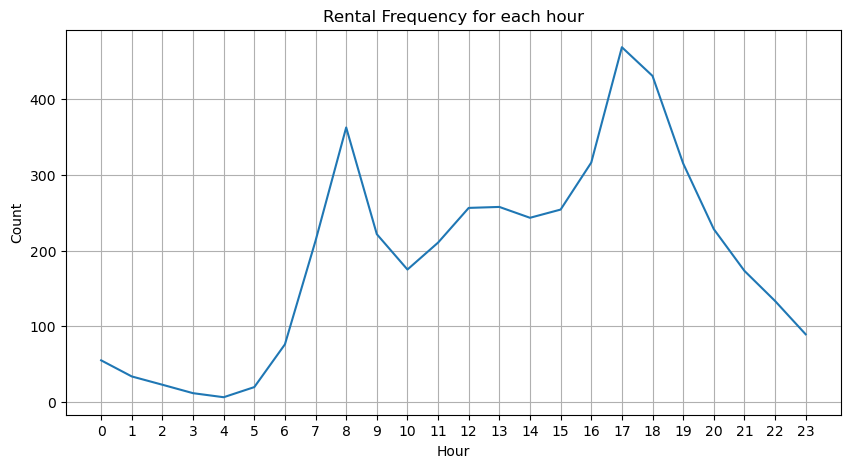

In [12]:
plt.figure(figsize=(10,5))
plt.plot(mean_hour.index, mean_hour)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid()
plt.title("Rental Frequency for each hour")
plt.show()

In [13]:
groupby_year_hour = train_data.groupby(['year', 'hour'])
mean_yearhour = groupby_year_hour['count'].mean()

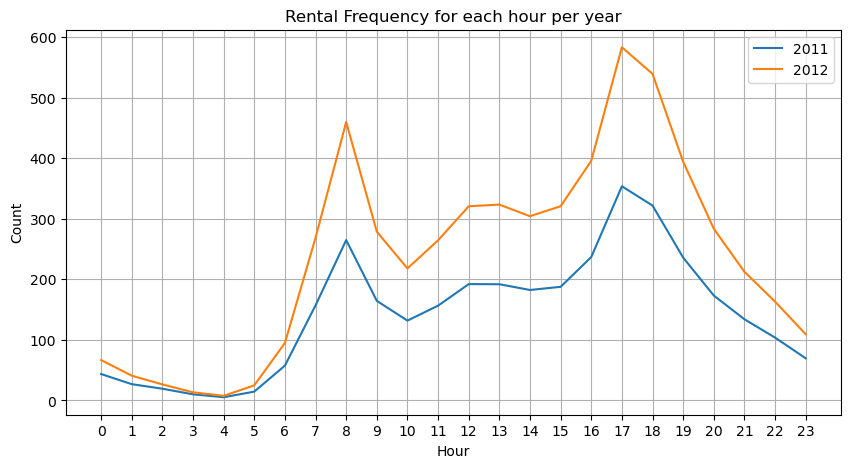

In [14]:
plt.figure(figsize=(10,5))
for year in mean_yearhour.index.levels[0]:
    plt.plot(mean_yearhour[year].index, mean_yearhour[year], label=year)


plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid()
plt.legend()
plt.title("Rental Frequency for each hour per year")
plt.show()

# Train and Validate

## Build Model

In [15]:
#Function for AdaBoost Regressor
def adaboost(x_train, x_test, y_train, y_test):
    start_time = timeit.default_timer()
    adaboost = AdaBoostRegressor(n_estimators=100, learning_rate=1, loss="exponential")
    adaboost.fit(x_train, y_train)
    run_time = timeit.default_timer()-start_time
    return adaboost, run_time

#Function for Random Forest Regressor
def random_forest(x_train, x_test, y_train, y_test):
    start_time = timeit.default_timer()
    random_forest = RandomForestRegressor(n_estimators=100)
    random_forest.fit(x_train, y_train)
    run_time = timeit.default_timer()-start_time
    return random_forest, run_time

## Split train and validation

In [16]:
train_data_count = train_data.shape[0]
train_count = int(train_data_count * 0.8)

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. For this example, we use CSV. It should have the following:

1. Have the target variable in the first column
2. Not have a header row


source: https://aws.amazon.com/blogs/machine-learning/simplify-machine-learning-with-xgboost-and-amazon-sagemaker/

In [17]:
train_data[:train_count].to_csv(train_file_loc, index=False, header=True)
train_data[train_count:].to_csv(validation_file_loc, index=False, header=True)

## Train and validate the Model

In [18]:
target = train_data["count"]
features = train_data.drop(columns=["humidity", "weather", "holiday", "casual", "registered", "count"], axis=1)
# features = (features-features.mean(axis=0))/features.std(axis=0)
# target = (target-target.mean(axis=0))/target.std(axis=0)
X = (features-features.min(axis=0))/(features.max(axis=0)-features.min(axis=0))
y = (target-target.min(axis=0))/(target.max(axis=0)-target.min(axis=0))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [19]:
adaboost_pred, adaboost_time = adaboost(x_train, x_test, y_train, y_test)
exp_variance_score_adaboost = explained_variance_score(y_test, adaboost_pred.predict(x_test))
print("\n The variance score for AdaBoost is {:.4f}\n".format(exp_variance_score_adaboost))
print("\n Time taken by Adaboost is {:.2f} seconds\n".format(adaboost_time))
print("\n RMSE for Adaboost is {:.2f} \n".format(np.sqrt(mean_squared_error(y_test, 
                                                                                 adaboost_pred.predict(x_test)))))



 The variance score for AdaBoost is 0.6672


 Time taken by Adaboost is 1.30 seconds


 RMSE for Adaboost is 0.13 



In [20]:
random_forest_pred, rf_time = random_forest(x_train, x_test, y_train, y_test)
exp_variance_score_rf = explained_variance_score(y_test, random_forest_pred.predict(x_test))
print("\n The variance score for Random Forest is {:.4f}\n".format(exp_variance_score_rf))
print("\n Time taken by Random Forest is {:.2f} seconds\n".format(rf_time))
print("\n RMSE for Random Forest is {:.2f} \n".format(np.sqrt(mean_squared_error(y_test, 
                                                                                 random_forest_pred.predict(x_test)))))
      


 The variance score for Random Forest is 0.9162


 Time taken by Random Forest is 3.77 seconds


 RMSE for Random Forest is 0.05 



# Test Model

In [21]:
test_features = test_data.drop(columns=["humidity", "weather", "holiday"], axis=1)
test_features = (test_features-test_features.mean(axis=0))/test_features.std(axis=0)
(adaboost_pred.predict(test_features) * (target.max(axis=0) - target.min(axis=0))) + target.min(axis=0)
# adaboost_pred.predict(test_features)

array([ 77.83820663,  96.95748988,  96.95748988, ..., 251.80999181,
       251.80999181, 251.80999181])

In [22]:
(random_forest_pred.predict(test_features) * (target.max(axis=0) - target.min(axis=0))) + target.min(axis=0)

array([ 6.46,  5.67,  5.67, ..., 70.98, 70.98, 70.98])

# Save Model

In [23]:
# Save model locally

with open("./adaboost-model", "wb") as f:
    joblib.dump(adaboost, f)    
    
with open("./randomforest-model", "wb") as f:
    joblib.dump(random_forest, f)
    
# Upload model and performance metrics to S3

adaboost_location = model_file + "/adaboost-model"
random_forest_location = model_file + "/randomforest-model"


s3_client.upload_file(Filename="./adaboost-model", Bucket=bucket_name, Key=adaboost_location)
s3_client.upload_file(Filename="./randomforest-model", Bucket=bucket_name, Key=random_forest_location)